# AA on toy data

Device:  cpu


 13%|█▎        | 1328/10000 [00:01<00:07, 1236.10it/s]


Tolerance reached at 1329 number of iterations


Text(0, 0.5, 'SSE')

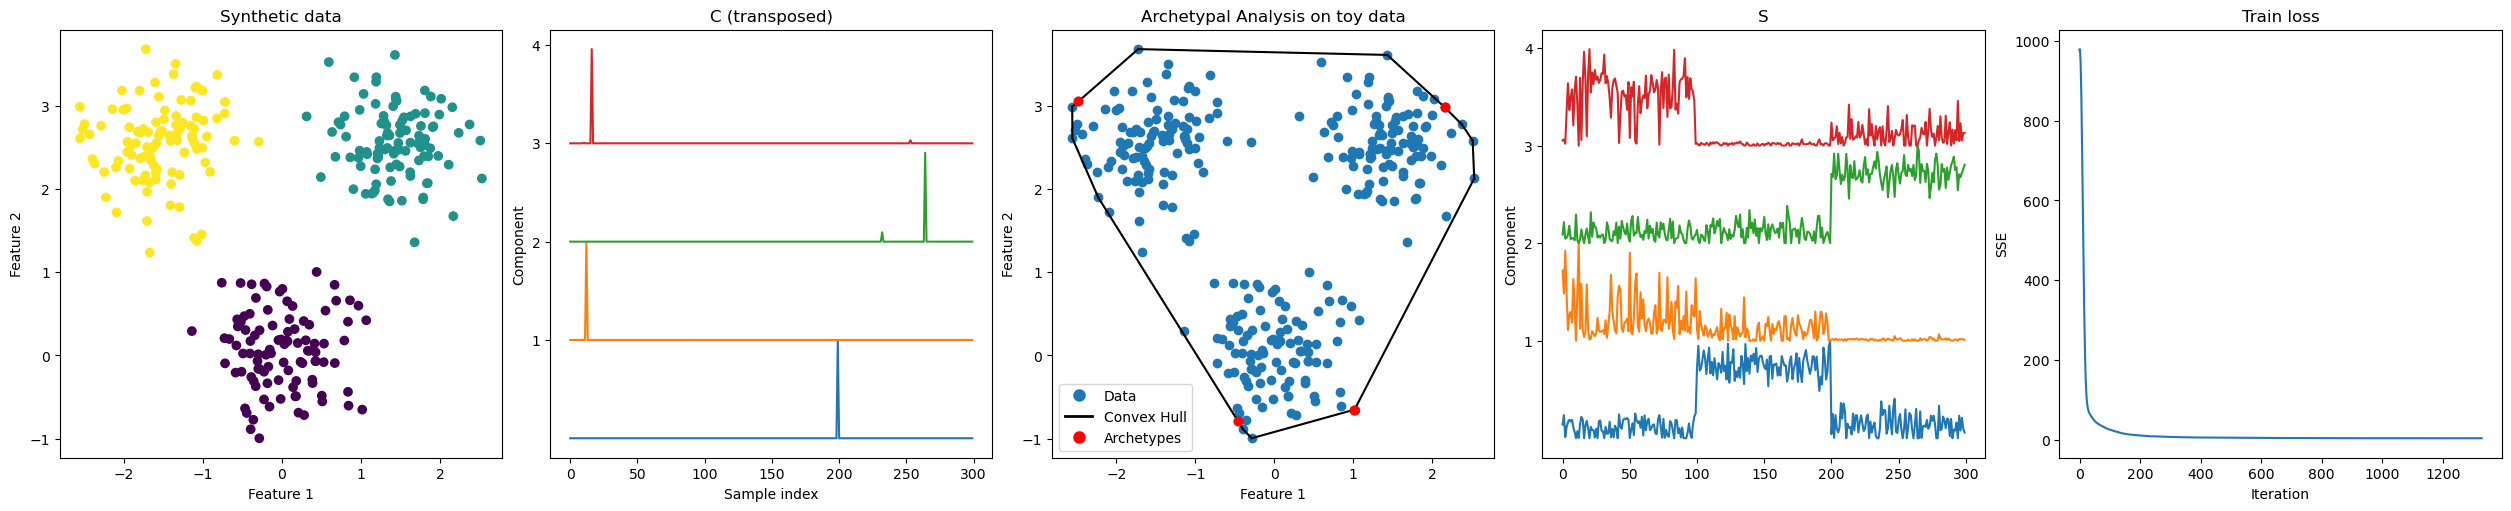

In [1]:
import sys
sys.path.append('../')
from CGD import AA_model, AA_trainer
from scipy.spatial import ConvexHull
import torch
import numpy as np
import matplotlib.pyplot as plt

# make 3 blobs of data using multivariate normal distribution
np.random.seed(0)
var = 0.2
n = 100
rad = (np.cos(30/(180/np.pi))*3)
X1 = np.random.multivariate_normal([0,0],[[var,0],[0,var]],n).T
X2 = np.random.multivariate_normal([1.5,rad],[[var,0],[0,var]],n).T
X3 = np.random.multivariate_normal([-1.5,rad],[[var,0],[0,var]],n).T

X = np.concatenate((X1,X2,X3),axis=1)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data = torch.tensor(X).to(device)

# scatter each label
labels = np.concatenate((np.zeros(n),np.ones(n),2*np.ones(n)))

# initialize an AA model with 4 components, where the data is provided in a dictionary
K = 4
model = AA_model.AA(X=data,num_comp=K,model='AA')

# specify an optimizer (don't set LR too high)
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

# train the model, the model stops training when the difference between lowest and second-lowest of the 5 latest losses is less than 1e-8
loss,_ = AA_trainer.Optimizationloop(model=model,optimizer=optimizer,max_iter=10000,tol=1e-6)

# get and detach parameters
C,S = model.get_model_params()
C = C.cpu().detach().numpy()
S = S.cpu().detach().numpy()

# plots
fig,axs = plt.subplots(1,5,figsize=(25,5),layout='constrained')
axs[0].scatter(X[0,:],X[1,:],c=labels)
axs[0].set_title('Synthetic data')
axs[0].set_xlabel('Feature 1')
axs[0].set_ylabel('Feature 2')
for k in range(K):
    axs[1].plot(C[:,k]+k)
axs[1].set_title('C (transposed)')
# use K
axs[1].set_yticks([k+1 for k in range(K)])
axs[1].set_yticklabels([k+1 for k in range(K)])
axs[1].set_ylabel('Component')
axs[1].set_xlabel('Sample index')

axs[2].scatter(X[0,:],X[1,:])

# of all the points in the data
hull = ConvexHull(X.T)
for simplex in hull.simplices:
    axs[2].plot(X[0,simplex],X[1,simplex],'k-')

#plot the archetypes on top of real data
XC = X@C
# for k in range(K):
    # plot a line between each archetype so it forms a convex hull
    # if k != K-1:
    #     axs[2].plot([XC[0,k],XC[0,k+1]],[XC[1,k],XC[1,k+1]],'r-')
    # else:
    #     axs[2].plot([XC[0,k],XC[0,0]],[XC[1,k],XC[1,0]],'r-')
axs[2].scatter(XC[0,:],XC[1,:],c='r', s=40, zorder=2)

# Custom legend
legend_labels = ['Data', 'Convex Hull', 'Archetypes']
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='#1f77b4', markersize=10, label=legend_labels[0]), plt.Line2D([0], [0], color='k', lw=2, label=legend_labels[1]), plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='r', markersize=10, label=legend_labels[2])]

axs[2].legend(legend_handles, legend_labels)
axs[2].set_title('Archetypal Analysis on toy data')
axs[2].set_xlabel('Feature 1')
axs[2].set_ylabel('Feature 2')

for k in range(K):
    axs[3].plot(S[k,:]+k)
axs[3].set_title('S')
axs[3].set_yticks([k+1 for k in range(K)])
axs[1].set_yticklabels([k+1 for k in range(K)])
axs[3].set_ylabel('Component')
axs[1].set_xlabel('Sample index')

axs[4].plot(loss)
axs[4].set_title('Train loss')
axs[4].set_xlabel('Iteration')
axs[4].set_ylabel('SSE')
#fig.savefig('AA_example.png')

### C, Archetype, and S plot

Text(0.5, 0, 'Sample index')

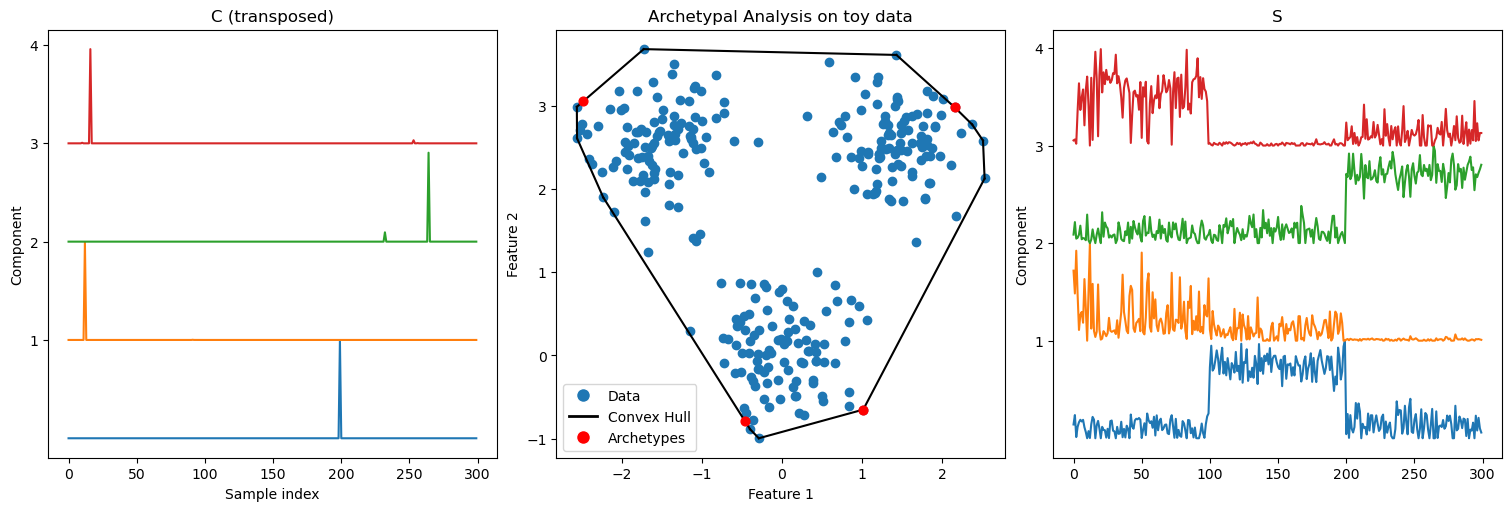

In [2]:
fig, axs = plt.subplots(1,3,figsize=(15,5),layout='constrained')
# show S, Archetypes and C
for k in range(K):
    axs[0].plot(C[:,k]+k)
axs[0].set_title('C (transposed)')
# use K
axs[0].set_yticks([k+1 for k in range(K)])
axs[0].set_yticklabels([k+1 for k in range(K)])
axs[0].set_ylabel('Component')
axs[0].set_xlabel('Sample index')

axs[1].scatter(X[0,:],X[1,:])

# of all the points in the data
hull = ConvexHull(X.T)
for simplex in hull.simplices:
    axs[1].plot(X[0,simplex],X[1,simplex],'k-')

#plot the archetypes on top of real data
XC = X@C

# for k in range(K):
    # plot a line between each archetype so it forms a convex hull
    # if k != K-1:
    #     axs[1].plot([XC[0,k],XC[0,k+1]],[XC[1,k],XC[1,k+1]],'r-')
    # else:
    #     axs[1].plot([XC[0,k],XC[0,0]],[XC[1,k],XC[1,0]],'r-')

axs[1].scatter(XC[0,:],XC[1,:],c='r', s=40, zorder=2)

# Custom legend
legend_labels = ['Data', 'Convex Hull', 'Archetypes']
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='#1f77b4', markersize=10, label=legend_labels[0]), plt.Line2D([0], [0], color='k', lw=2, label=legend_labels[1]), plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='r', markersize=10, label=legend_labels[1])]

axs[1].legend(legend_handles, legend_labels)
axs[1].set_title('Archetypal Analysis on toy data')
axs[1].set_xlabel('Feature 1')
axs[1].set_ylabel('Feature 2')

for k in range(K):
    axs[2].plot(S[k,:]+k)
axs[2].set_title('S')
axs[2].set_yticks([k+1 for k in range(K)])
axs[0].set_yticklabels([k+1 for k in range(K)])
axs[2].set_ylabel('Component')
axs[0].set_xlabel('Sample index')

### Datapoints represented by Archetypes

Device:  cuda


  9%|▉         | 946/10000 [00:01<00:13, 683.84it/s]


Tolerance reached at 947 number of iterations


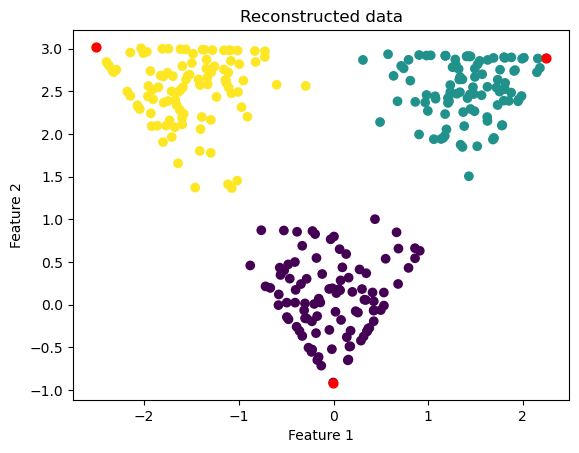

In [3]:
K = 3
model = AA_model.AA(X=data,num_comp=K,model='AA')
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
loss,_ = AA_trainer.Optimizationloop(model=model,optimizer=optimizer,max_iter=10000,tol=1e-6)
C, S = model.get_model_params()
C, S = C.cpu().detach().numpy(), S.cpu().detach().numpy()
XC = X@C
X_reconstructed = XC@S
plt.scatter(X_reconstructed[0,:],X_reconstructed[1,:],c=labels)
plt.scatter(XC[0,:],XC[1,:],c='r', s=40, zorder=2)
plt.title('Reconstructed data')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

# Data Loading

In [3]:
import sys
sys.path.append('../')
from CGD import AA_model, AA_trainer
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from data import load_data, load_config

# slowdelta, fastdelta, slowtheta, fasttheta, alpha, beta, rms, mouseID, lab, sleepstage, epoch
config = load_config()
data_path = config['data_path']
df = load_data(data_path)
# unique id, L{lab},M{mouseID}
df['unique_id'] = df['lab'].astype(str) + '_' + df['mouseID'].astype(str)
df['unique_id'] = df['unique_id'].astype('category').cat.codes + 1
df = df.sort_values('unique_id')
df

,slowdelta,fastdelta,slowtheta,fasttheta,alpha,beta,gamma,rms,mouseID,lab,sleepstage,epoch,unique_id
0,528.584023,370.200447,235.735391,205.805979,75.988092,13.273196,1.274694,0.464923,1.0,1.0,3.0,1.0,1
41184,116.615201,546.520451,190.645089,93.537159,69.205322,10.751717,0.757866,0.577114,1.0,1.0,3.0,43255.0,1
41185,645.094894,227.352963,166.548351,87.381527,49.106154,9.185074,1.245053,0.565131,1.0,1.0,3.0,43256.0,1
41186,424.385826,372.442339,165.275745,118.518396,95.574608,12.109673,0.868221,0.579700,1.0,1.0,3.0,43257.0,1
41187,351.033633,224.878174,353.158072,253.845599,145.775869,11.105222,0.716420,0.573834,1.0,1.0,3.0,43258.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1879140,284.110560,222.186698,35.627151,40.795977,29.705343,7.462802,1.872521,0.486890,9.0,5.0,3.0,7178.0,150
1879139,179.342783,176.346349,51.367199,23.391804,11.479414,5.258740,1.472480,2.963182,9.0,5.0,3.0,7177.0,150
1879138,345.407766,267.607792,40.329804,27.410197,29.182522,5.665849,1.104752,0.462965,9.0,5.0,3.0,7176.0,150
1879146,392.315644,1015.969768,322.228194,106.472836,122.871352,18.025534,2.875785,0.469426,9.0,5.0,3.0,7184.0,150


### Only using data from Lab 1

In [5]:
lab1 = df[df['lab'] == 1]
lab1 = lab1.drop(columns=['mouseID', 'lab', 'unique_id', 'epoch'])
# sort data by sleepstage
lab1 = lab1.sort_values('sleepstage')
lab1np = lab1.to_numpy()
# save the data to npy file
np.save('data/lab1.npy', lab1np)

### Only using data from Mouse 1

In [6]:
mouse1 = df[df['unique_id'] == 1]
mouse1 = mouse1.drop(columns=['mouseID', 'lab', 'unique_id', 'epoch'])
# sort data by sleepstage
mouse1 = mouse1.sort_values('sleepstage')
mouse1np = mouse1.to_numpy()
# save the data to npy file
np.save('data/mouse1.npy', mouse1np)

# Importing data from subgroups

In [7]:
import sys
sys.path.append('../')
from CGD import AA_model, AA_trainer
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

load = np.load('data/lab1.npy')
df = pd.DataFrame(load, columns=['slowdelta', 'fastdelta', 'slowtheta', 'fasttheta', 'alpha', 'beta', 'rms', 'sleepstage'])
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df['rms'] = scaler.fit_transform(df[['rms']])
df

ValueError: Shape of passed values is (619534, 9), indices imply (619534, 8)

In [8]:
X = df.drop(columns=['sleepstage'])
y = df['sleepstage']
X = X.to_numpy()
y = y.to_numpy()
X = X.T

# Using a subset of the data

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Equal amount of data per sleepstage
idx = []
for i in range(1, 4):
    idx.extend(np.random.choice(np.where(y == i)[0], 30000))

# Random data
# n = len(y)
# idx = np.random.choice(len(y), n, replace=False)

sorted_idx = np.sort(idx)
X = X[:, sorted_idx]
data = torch.tensor(X).to(device)
y = (y[sorted_idx]).astype(int)

X.shape

(12, 90000)

In [13]:
y

array([3, 3, 3, ..., 3, 2, 3])

In [10]:
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# data = {'X': torch.tensor(mouse1X).to(device)}
# mouse1X.shape

### Hypnogram of sleepstages (sorted)

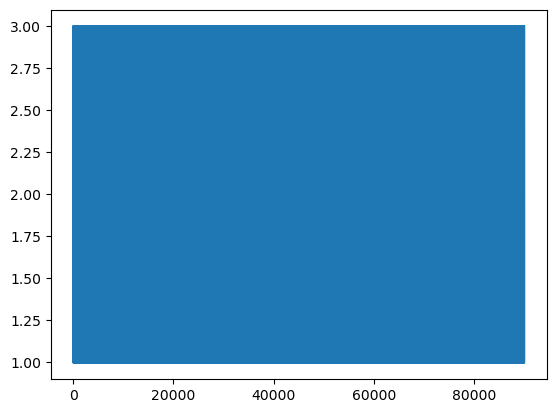

In [11]:
# Hypno of mouse 1
plt.plot(y)
plt.show()

# Training a single AA model

In [16]:
K = 5
model = AA_model.AA(X=data, num_comp=K, model='AA', verbose=True)
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
loss,_ = AA_trainer.Optimizationloop(model=model,optimizer=optimizer,max_iter=10000,tol=1e-6, disable_output=False)
C, S = model.get_model_params()
C, S = C.cpu().detach().numpy(), S.cpu().detach().numpy()

Initializing model: AA
Model initialized in 0.020001888275146484 seconds
Device:  cpu


  0%|          | 0/10000 [00:00<?, ?it/s]

 11%|█         | 1089/10000 [00:41<05:36, 26.51it/s]

Tolerance reached at 1090 number of iterations


In [17]:
S
# Save the S matrix
np.save('data/S1.npy', S)

### Archetype coordinates

In [13]:
X@C

array([[0.15722678, 0.03376308, 0.86384956, 0.04704119, 0.04293391],
       [0.18600058, 0.64414157, 0.05358153, 0.0140048 , 0.02017838],
       [0.26600807, 0.07902803, 0.03220839, 0.76457868, 0.08595664],
       [0.11249812, 0.02117241, 0.01379684, 0.03770089, 0.57104152],
       [0.11364404, 0.07451439, 0.01550346, 0.04035819, 0.45719551],
       [0.11082997, 0.04221603, 0.01108431, 0.08698261, 0.11882373],
       [0.90913044, 0.05102721, 0.41672971, 0.0360865 , 0.06863068]])

### Plot of archetypes projected on the 2D/3D space

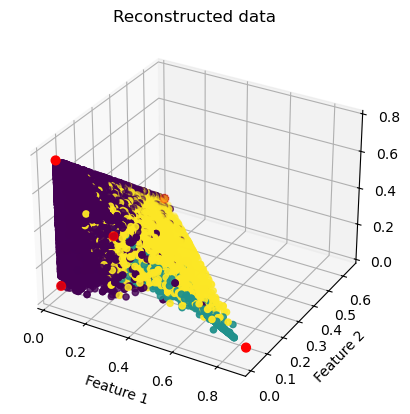

In [14]:
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
XC = X@C
X_reconstructed = XC@S

# 2d plot
# plt.scatter(X_reconstructed[0,:], X_reconstructed[1,:], c=y)
# plt.scatter(XC[0,:], XC[1,:], c='r', s=40, zorder=2)
# plt.title('Reconstructed data')
# plt.xlabel('Feature 1')
# plt.ylabel('Feature 2')
# plt.show()

# 3d plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_reconstructed[0,:], X_reconstructed[1,:], X_reconstructed[2,:], c=y)
ax.scatter(XC[0,:], XC[1,:], XC[2,:], c='r', s=40, zorder=2)
plt.title('Reconstructed data')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

# Plot of matrix S

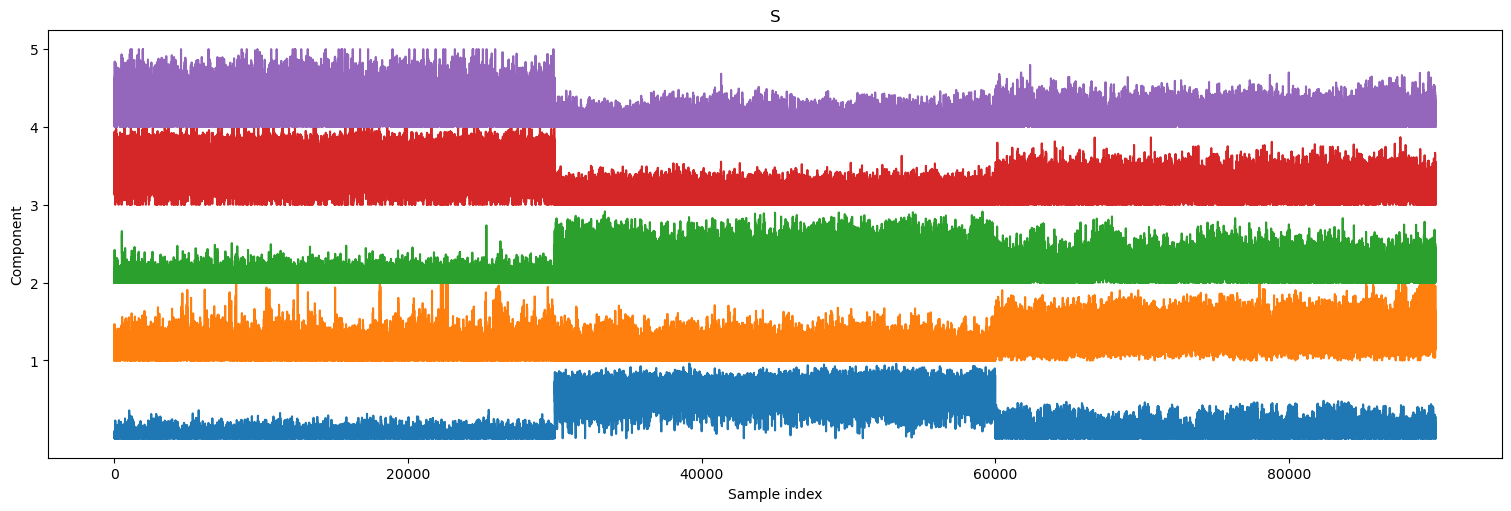

In [15]:
%matplotlib inline
fig, axs = plt.subplots(1,1,figsize=(15,5),layout='constrained')
for k in range(K):
    axs.plot(S[k,:]+k)
axs.set_title('S')
axs.set_yticks([k+1 for k in range(K)])
axs.set_yticklabels([k+1 for k in range(K)])
axs.set_ylabel('Component')
axs.set_xlabel('Sample index')

plt.show()

### Single Archetype plot

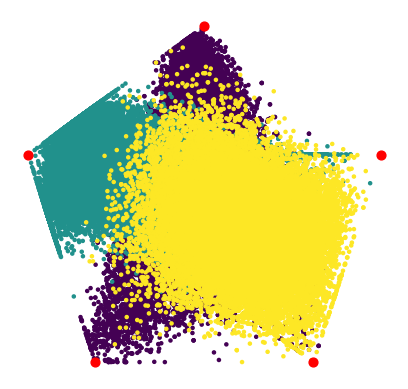

In [16]:
# project the 5 archetypes onto a pentagon graph
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.set_aspect('equal')
ax.set_axis_off()

xs, ys = np.cos(2*np.pi/K*np.arange(K)+np.pi/2)*0.4 + 0.5, np.sin(2*np.pi/K*np.arange(K)+np.pi/2)*0.4 + 0.5
archetypes = np.stack((xs, ys))

distances = np.sqrt(np.sum((archetypes[:, :, np.newaxis] - (archetypes@S)[:, np.newaxis, :])**2, axis=0))
closest_indices = np.argsort(distances, axis=1)[:, :10]
majority_labels = np.array([np.argmax(np.bincount(y[indices])) for indices in closest_indices])
sorted_indices = np.argsort(majority_labels)
sorted_archetypes = archetypes[:, sorted_indices]
sorted_reconstruction = sorted_archetypes@S

# Plotting
plt.scatter(sorted_reconstruction[0, :], sorted_reconstruction[1, :], c=y, s=5)
plt.scatter(sorted_archetypes[0, :], sorted_archetypes[1, :], c='r', s=40, zorder=2)
plt.show()

# AA training for different values of K

In [17]:
from tqdm import tqdm
K_list = [2, 3, 4, 5, 6, 7, 8, 9, 10]

C_list = []
S_list = []

for K in tqdm(K_list):
    model = AA_model.AA(X=data,num_comp=K,model='AA', verbose=False)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
    loss,_ = AA_trainer.Optimizationloop(model=model,optimizer=optimizer,max_iter=10000,tol=1e-6, disable_output=True)
    C, S = model.get_model_params()
    C_list.append(C.cpu().detach().numpy())
    S_list.append(S.cpu().detach().numpy())

100%|██████████| 9/9 [01:45<00:00, 11.74s/it]


### Plotting archetypes for different values of K

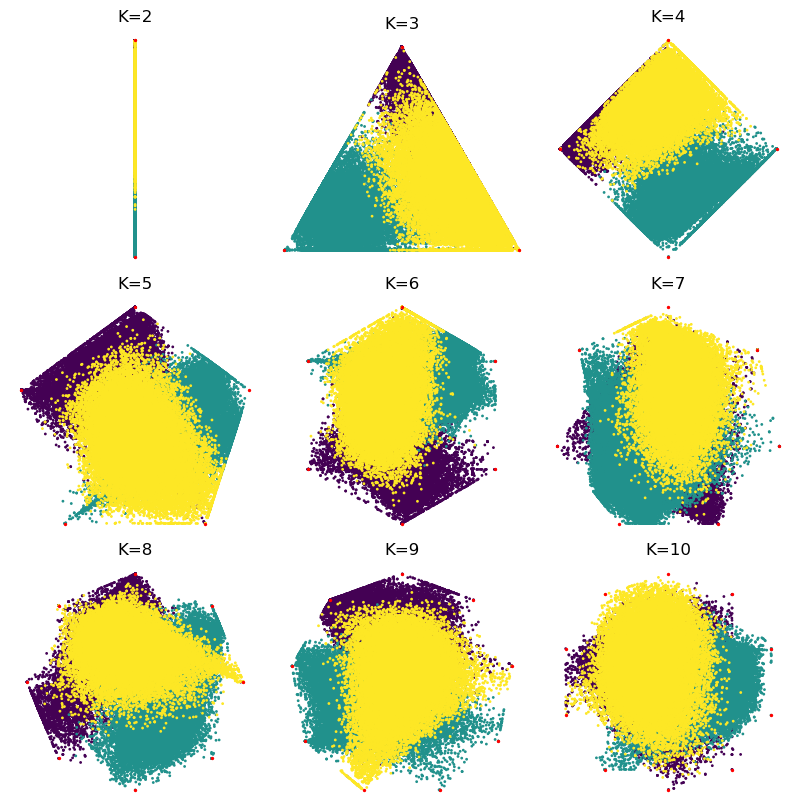

In [18]:
fig, axs = plt.subplots(3, 3, figsize=(8, 8), layout='constrained')

for i, K in enumerate(K_list):
    XC = X@C_list[i]
    xs, ys = np.cos(2*np.pi/K*np.arange(K)+np.pi/2)*0.4 + 0.5, np.sin(2*np.pi/K*np.arange(K)+np.pi/2)*0.4 + 0.5
    archetypes = np.stack((xs, ys))
    X_reconstructed = archetypes@S_list[i]

    ax = axs[(K-2)//3][(K-2)%3]
    ax.set_aspect('equal')
    ax.set_axis_off()

    distances = np.sqrt(np.sum((archetypes[:, :, np.newaxis] - X_reconstructed[:, np.newaxis, :])**2, axis=0))
    closest_indices = np.argsort(distances, axis=1)[:, :50]
    majority_labels = np.array([np.argmax(np.bincount(y[indices])) for indices in closest_indices])
    sorted_indices = np.argsort(majority_labels)
    sorted_archetypes = archetypes[:, sorted_indices]
    sorted_reconstruction = sorted_archetypes@S_list[i]

    ax.scatter(sorted_archetypes[0,:], sorted_archetypes[1,:], c='r', s=2, zorder=2)
    ax.scatter(sorted_reconstruction[0,:], sorted_reconstruction[1,:], c=y, s=1)
    ax.set_title(f'K={K}')

plt.show()

# Evaluation

In [19]:
from tqdm import tqdm
K_list = [2, 3, 4, 5, 6, 7, 8, 9, 10]
var_explained = []
std_var_explained = []

for K in tqdm(K_list):
    var_explained_K = []
    for i in range(10):
        model = AA_model.AA(X=data,num_comp=K,model='AA', verbose=False)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
        loss,_ = AA_trainer.Optimizationloop(model=model,optimizer=optimizer,max_iter=10000,tol=1e-6, disable_output=True)
        C, S = model.get_model_params()
        C, S = C.cpu().detach().numpy(), S.cpu().detach().numpy()
        XC = X@C
        X_reconstructed = XC@S
        SSE = np.sum((X - X_reconstructed)**2)
        SST = np.sum((X - np.mean(X, axis=1, keepdims=True))**2)
        var_explained_K.append(1 - (SSE / SST))

    var_explained.append(np.mean(var_explained_K))
    std_var_explained.append(np.std(var_explained_K))

100%|██████████| 9/9 [15:36<00:00, 104.05s/it]


### Variance explained

In [20]:
# save the results
np.save('plot_data/var_explained.npy', var_explained)
np.save('plot_data/std_var_explained.npy', std_var_explained)

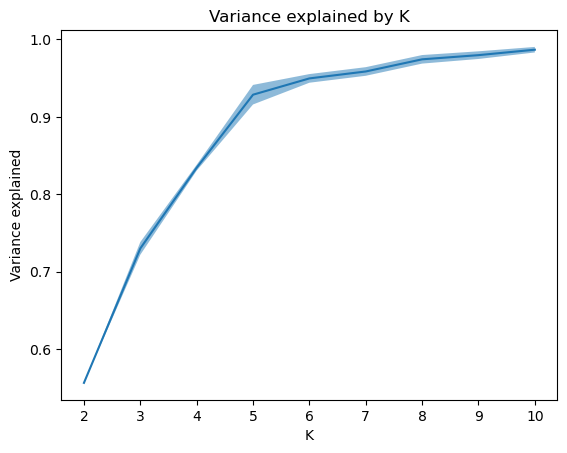

In [21]:
# plot error with fillbetween
var_explained = np.load('plot_data/var_explained.npy')
std_var_explained = np.load('plot_data/std_var_explained.npy')
plt.fill_between(K_list, np.array(var_explained) - np.array(std_var_explained), np.array(var_explained) + np.array(std_var_explained), alpha=0.5)
plt.plot(K_list, var_explained)
plt.xlabel('K')
plt.ylabel('Variance explained')
plt.title('Variance explained by K')
plt.show()

### Classifier on S

In [22]:
# train a classifier on the S matrix
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

acc_list = []
std_acc_list = []

# tqdm
for i, K in enumerate(tqdm(K_list)): 
    acc_list_K = []
    for j in range(10):
        X_train, X_test, y_train, y_test = train_test_split(S_list[i].T, y, test_size=0.2, random_state=42)
        clf = RandomForestClassifier(n_estimators=10)
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        acc_list_K.append(acc)
        
    acc_list.append(np.mean(acc_list_K))
    std_acc_list.append(np.std(acc_list_K))

# save the results
np.save('plot_data/acc_list.npy', acc_list)
np.save('plot_data/std_acc_list.npy', std_acc_list)

100%|██████████| 9/9 [06:19<00:00, 42.16s/it]


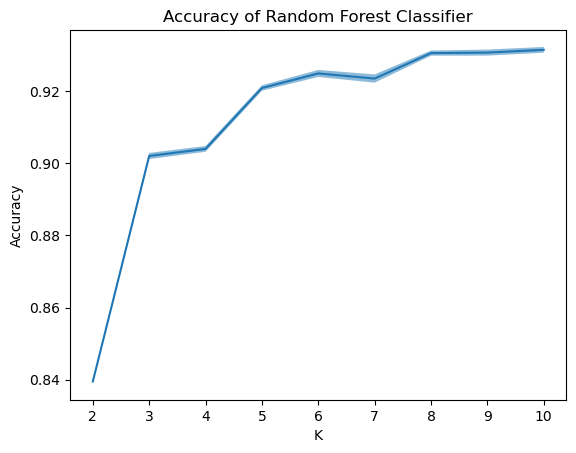

In [23]:
# Plot
import numpy as np
import matplotlib.pyplot as plt
K_list = [2, 3, 4, 5, 6, 7, 8, 9, 10]
acc_list = np.load('plot_data/acc_list.npy')
std_acc_list = np.load('plot_data/std_acc_list.npy')
plt.fill_between(K_list, np.array(acc_list) - np.array(std_acc_list), np.array(acc_list) + np.array(std_acc_list), alpha=0.5)
plt.plot(K_list, acc_list)
plt.xlabel('K')
plt.ylabel('Accuracy')
plt.title('Accuracy of Random Forest Classifier')
plt.show()

### Error

In [24]:
errors = X-X@C@S
# max abs error
print('Max abs error:',np.max(np.abs(errors)))
# mean abs error
print('Mean abs error:',np.mean(np.abs(errors)))

Max abs error: 0.7704138742720161
Mean abs error: 0.007817563543739444


### NMI

In [25]:
# NMI, only works with 3 archetypes
# from sklearn.metrics import normalized_mutual_info_score
# # predicted labels
# pred_labels = np.argmax(S,axis=0).flatten()
# # NMI
# NMI = normalized_mutual_info_score(y,pred_labels)
# print('NMI:',NMI)